In [4]:
import pandas as pd
import h5py
import hdf5plugin
from datetime import datetime

# Path to UK-DALE HDF5 file
file_path = '/users/kjain/Downloads/ukdale.h5'

# Define a manual mapping of meters to appliances (Update if needed)
# Define a manual mapping of meters to appliances
# Define a manual mapping of meters to appliances
# Define a manual mapping of meters to appliances
meter_mapping = {
    'meter1': 'Main Power',
    'meter2': 'stereo_speakers_bedroom',
    'meter3': 'i7_desktop',
    'meter4': 'hairdryer',
    'meter5': 'primary_tv',
    'meter6': '24_inch_lcd_bedroom',
    'meter7': 'treadmill',
    'meter8': 'network_attached_storage',
    'meter9': 'core2_server',
    'meter10': '24_inch_lcd',
    'meter11': 'PS4',
    'meter12': 'steam_iron',
    'meter13': 'nespresso_pixie',
    'meter14': 'atom_pc',
    'meter15': 'toaster',
    'meter16': 'home_theatre_amp',
    'meter17': 'sky_hd_box',
    'meter18': 'kettle',
    'meter19': 'fridge_freezer',
    'meter20': 'oven',
    'meter21': 'electric_hob',
    'meter22': 'dishwasher',
    'meter23': 'microwave',
    'meter24': 'washer_dryer',
    'meter25': 'vacuum_cleaner'
}


# Open the HDF5 file
with h5py.File(file_path, 'r') as hdf:
    print("Keys:", list(hdf.keys())) # Check available buildings

    # Navigate to House 1's electricity data
    house_path = 'building5/elec'
    house_data = hdf[house_path]

    # List to store DataFrames for each meter
    meter_dfs = []

    # Process meters (select relevant meters based on mapping)
    for meter_id in meter_mapping.keys():
        meter_path = f"{house_path}/{meter_id}"

        if "table" in house_data[meter_id]:
            print(f"Processing {meter_id} ({meter_mapping[meter_id]})...")
            table_data = house_data[meter_id]['table']
            
            # Read data in chunks (optimized for memory usage)
            timestamps = []
            power_values = []

            for entry in table_data[:500000]: # Read only 500,000 entries at a time
                timestamp, power = entry
                timestamps.append(datetime.utcfromtimestamp(timestamp / 1e9)) # Convert nanoseconds
                power_values.append(power[0]) # Extract first power value

            # Create DataFrame
            df_meter = pd.DataFrame({'timestamp': timestamps, meter_mapping[meter_id]: power_values})

            # Append to list (we will merge later)
            meter_dfs.append(df_meter)

    # Merge all meter DataFrames on timestamp
    df = meter_dfs[0]
    for meter_df in meter_dfs[1:]:
        df = df.merge(meter_df, on='timestamp', how='outer') # Outer join to include all timestamps

    # Convert timestamp to DateTimeIndex
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df.set_index('timestamp', inplace=True)

    # ✅ Filter for January 2013
    df_month = df.loc['2014-06-29':'2014-07-29']

    # Save to CSV
    df_month.to_csv('house5_january2013_some_appliances.csv')

print("✅ Data saved to house5_january2013_some_appliances.csv")

Keys: ['building1', 'building2', 'building3', 'building4', 'building5']
Processing meter1 (Main Power)...
Processing meter2 (stereo_speakers_bedroom)...
Processing meter3 (i7_desktop)...
Processing meter4 (hairdryer)...
Processing meter5 (primary_tv)...
Processing meter6 (24_inch_lcd_bedroom)...
Processing meter7 (treadmill)...
Processing meter8 (network_attached_storage)...
Processing meter9 (core2_server)...
Processing meter10 (24_inch_lcd)...
Processing meter11 (PS4)...
Processing meter12 (steam_iron)...
Processing meter13 (nespresso_pixie)...
Processing meter14 (atom_pc)...
Processing meter15 (toaster)...
Processing meter16 (home_theatre_amp)...
Processing meter17 (sky_hd_box)...
Processing meter18 (kettle)...
Processing meter19 (fridge_freezer)...
Processing meter20 (oven)...
Processing meter21 (electric_hob)...
Processing meter22 (dishwasher)...
Processing meter23 (microwave)...
Processing meter24 (washer_dryer)...
Processing meter25 (vacuum_cleaner)...
✅ Data saved to house5_jan

/var/folders/sj/1c1l30xn36dgw92bwyf1rn_w0000gp/T/ipykernel_3659/1130698995.py:12: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_resampled = df.resample('1H').mean()


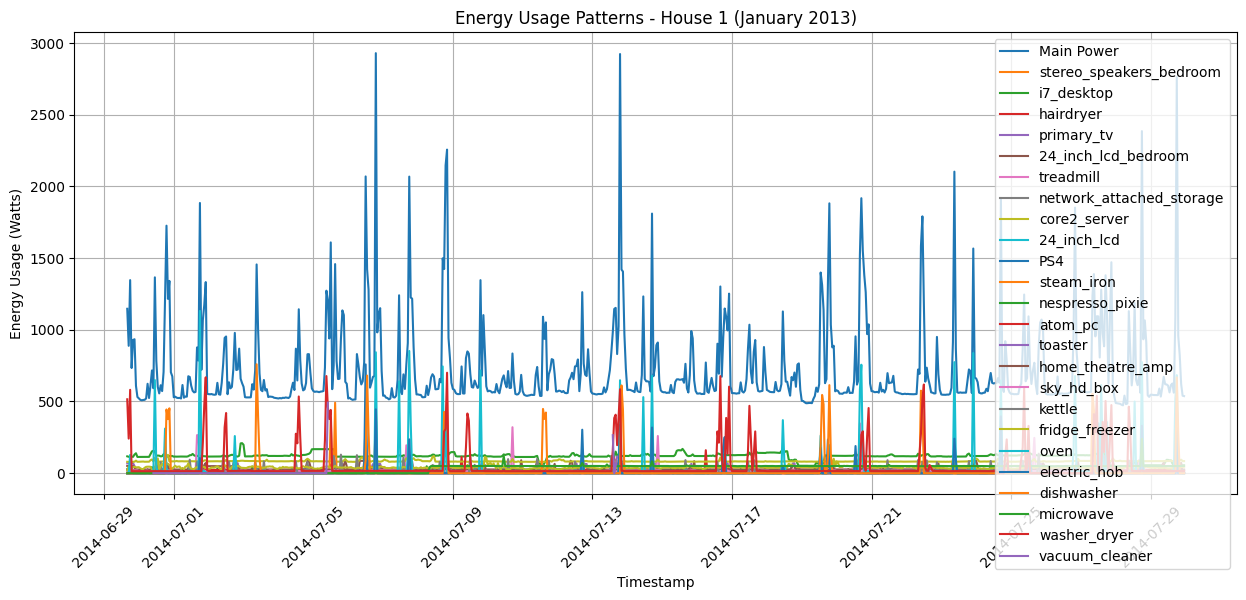

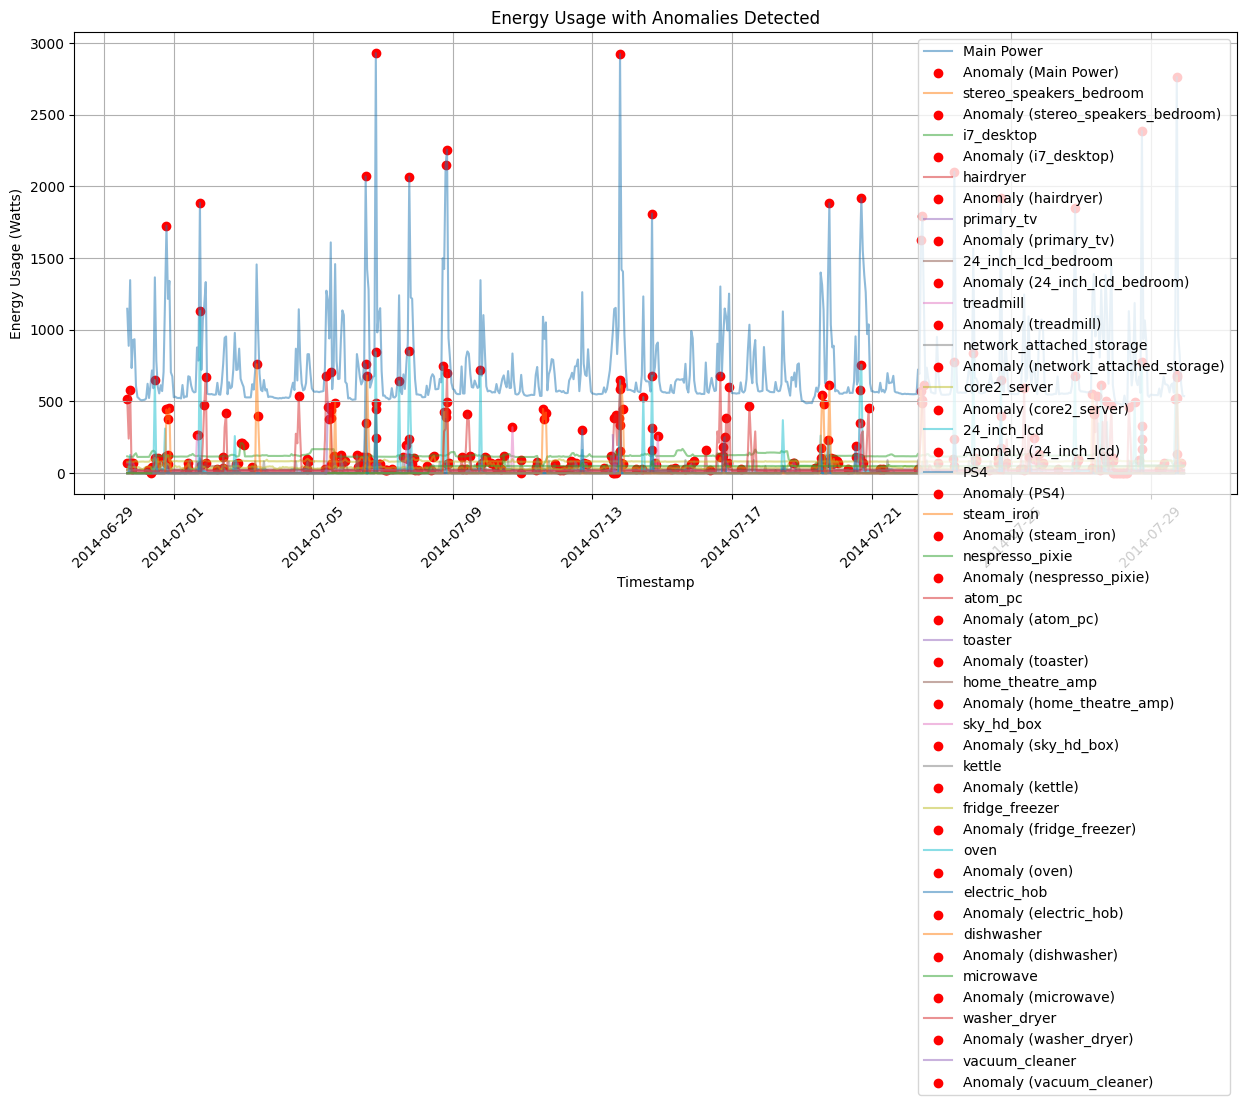


Anomalies in Main Power:
timestamp
2014-06-30 19:00:00    1726.178947
2014-07-01 18:00:00    1884.662609
2014-07-06 12:00:00    2069.711712
2014-07-06 19:00:00    2929.608929
2014-07-07 18:00:00    2068.527928
2014-07-08 19:00:00    2146.479927
2014-07-08 20:00:00    2256.894265
2014-07-13 19:00:00    2923.515152
2014-07-14 17:00:00    1810.616387
2014-07-19 19:00:00    1882.069565
2014-07-20 17:00:00    1917.887454
2014-07-22 11:00:00    1791.333333
2014-07-23 09:00:00    2103.090090
2014-07-24 17:00:00    1920.314019
2014-07-26 20:00:00    1852.080702
2014-07-28 18:00:00    2385.732965
2014-07-29 18:00:00    2762.343154
Name: Main Power, dtype: float64

Anomalies in stereo_speakers_bedroom:
timestamp
2014-07-10 23:00:00    1.063248
2014-07-13 14:00:00    1.169779
2014-07-13 15:00:00    1.499148
2014-07-13 16:00:00    1.079392
Name: stereo_speakers_bedroom, dtype: float64

Anomalies in i7_desktop:
timestamp
2014-07-02 22:00:00    207.680961
2014-07-02 23:00:00    209.242321
2014-07-0

In [5]:
import pandas as pd
import numpy as np
import hdf5plugin
import h5py
import matplotlib.pyplot as plt

# Load the CSV file
file_path = '/users/kjain/Project/house5_january2013_some_appliances.csv'
df = pd.read_csv(file_path, parse_dates=['timestamp'], index_col='timestamp')

# Resample data to hourly mean to reduce noise
df_resampled = df.resample('1H').mean()

# Plot Time Series Data
plt.figure(figsize=(15, 6))
for column in df_resampled.columns:
    plt.plot(df_resampled.index, df_resampled[column], label=column)

plt.xlabel('Timestamp')
plt.ylabel('Energy Usage (Watts)')
plt.title('Energy Usage Patterns - House 1 (January 2013)')
plt.legend()
plt.xticks(rotation=45)
plt.grid()
plt.show()

# --- Anomaly Detection ---
# Define threshold using standard deviation
threshold = 3 # Adjust this if needed
mean_usage = df_resampled.mean()
std_dev = df_resampled.std()

# Identify anomalies (values beyond mean ± threshold * std deviation)
anomalies = ((df_resampled - mean_usage).abs() > (threshold * std_dev))

# Plot Anomalies
plt.figure(figsize=(15, 6))
for column in df_resampled.columns:
    plt.plot(df_resampled.index, df_resampled[column], label=column, alpha=0.5)
    anomaly_points = df_resampled[column][anomalies[column]]
    plt.scatter(anomaly_points.index, anomaly_points, color='red', label=f'Anomaly ({column})')

plt.xlabel('Timestamp')
plt.ylabel('Energy Usage (Watts)')
plt.title('Energy Usage with Anomalies Detected')
plt.legend()
plt.xticks(rotation=45)
plt.grid()
plt.show()

# Print anomaly timestamps
for column in df_resampled.columns:
    print(f"\nAnomalies in {column}:")
    print(df_resampled[column][anomalies[column]].dropna())